In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [4]:

X_train, y_train, trainy_one_hot, X_test, y_test, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", X_train.shape)
print("Y train shape: ", y_train.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", X_test.shape)
print("Y test shape: ", y_test.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(y_train == 0)[0].size)
print("1: WU:" ,np.where(y_train == 1)[0].size)
print("2: WD:" ,np.where(y_train == 2)[0].size)
print("3: Sitting:" ,np.where(y_train == 3)[0].size)
print("4: Standing:" ,np.where(y_train == 4)[0].size)
print("5: Laying:" ,np.where(y_train == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
static_y_train = np.where((y_train >= 0) & (y_train <= 2), 0, 1)
static_y_test = np.where((y_test >= 0) & (y_test <= 2), 0, 1)

In [8]:
unique, counts = np.unique(static_y_train, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(static_y_test, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 3285]
 [   1 4067]]
Test data label statistics::
[[   0 1387]
 [   1 1560]]


In [9]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [10]:
X_train = flatten(X_train)
X_test = flatten(X_test)

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split (X_train, static_y_train, stratify = static_y_train, test_size=0.3,random_state=100)

In [12]:
print("X train shape: ", X_train.shape)
print("Y train shape: ", static_y_train.shape)

print("X test shape: ", X_test.shape)
print("Y test shape: ", static_y_test.shape)



X train shape:  (5146, 9)
Y train shape:  (7352, 1)
X test shape:  (2947, 9)
Y test shape:  (2947, 1)


# ML

In [13]:
print ("==================================")
print (" ACCURACY OF OTHER ML CLASSIFIERS" )
print ("==================================")


 ACCURACY OF OTHER ML CLASSIFIERS


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# SVM


--- SVM Classifier ---
f1_score =  0.9626626083809381
0.16016287750254496
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1387
           1       0.96      0.97      0.96      1560

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



<Axes: >

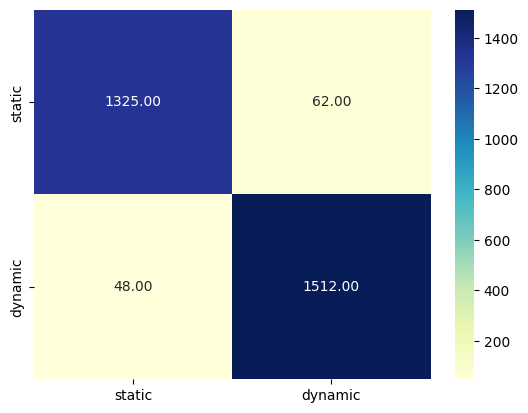

In [18]:
warnings.filterwarnings('ignore')

clf_svm = SVC(random_state=0)
clf_svm.fit(X_train, y_train)

pred_svm = clf_svm.predict(X_test)

print("\n--- SVM Classifier ---")

y_pred= pred_svm

LABELS = ['static','dynamic']
cm=confusion_matrix(static_y_test,y_pred)

#print(cm)
print('f1_score = ', f1_score(static_y_test, y_pred, average='weighted'))
print(accuracy_score(y_test,y_pred))
print(classification_report(static_y_test,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')


# Random Forest


--- Radom Forest ---

--- RF Classifier ---
f1_score =  0.9911800277102301
0.991177468612148
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1387
           1       1.00      0.99      0.99      1560

    accuracy                           0.99      2947
   macro avg       0.99      0.99      0.99      2947
weighted avg       0.99      0.99      0.99      2947



<Axes: >

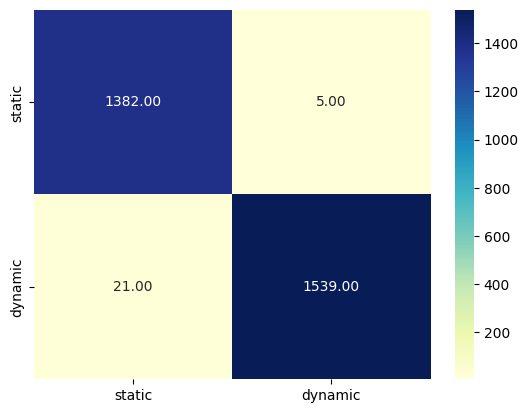

In [20]:
warnings.filterwarnings('ignore')

print ("\n--- Radom Forest ---")
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)

pred_clf = rf_clf.predict(X_test)

print("\n--- RF Classifier ---")

LABELS = ['static','dynamic']
y_pred= pred_clf
cm=confusion_matrix(static_y_test,y_pred)

#print(cm)
print('f1_score = ', f1_score(static_y_test, y_pred, average='weighted'))
print(accuracy_score(static_y_test,y_pred))
print(classification_report(static_y_test,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# # LogisticRegression




--- LR Classifier ---
f1_score =  0.7386445926713038
0.7387173396674585
              precision    recall  f1-score   support

           0       0.70      0.79      0.74      1387
           1       0.79      0.69      0.74      1560

    accuracy                           0.74      2947
   macro avg       0.74      0.74      0.74      2947
weighted avg       0.74      0.74      0.74      2947



<Axes: >

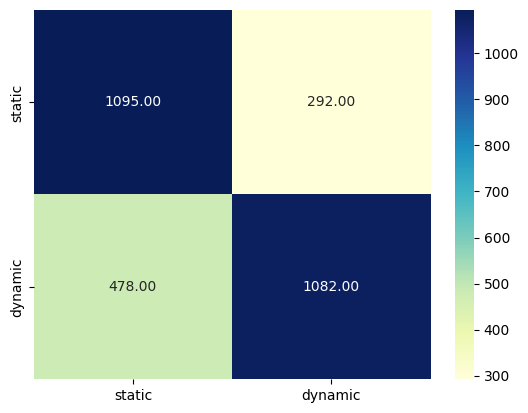

In [21]:
# Build a logistic regression classifier and predict

clf_lr = LogisticRegression(random_state=0)
clf_lr.fit(X_train, y_train)

pred_lr = clf_lr.predict(X_test)

print("\n--- LR Classifier ---")

y_pred= pred_lr

LABELS = ['static','dynamic']
cm=confusion_matrix(static_y_test,y_pred)

#print(cm)
print('f1_score = ', f1_score(static_y_test, y_pred, average='weighted'))
print(accuracy_score(static_y_test,y_pred))
print(classification_report(static_y_test,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Decision TreeClassifier


--- DT Classifier ---
f1_score =  0.9813373237127272
0.9813369528333898
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1387
           1       0.98      0.98      0.98      1560

    accuracy                           0.98      2947
   macro avg       0.98      0.98      0.98      2947
weighted avg       0.98      0.98      0.98      2947



<Axes: >

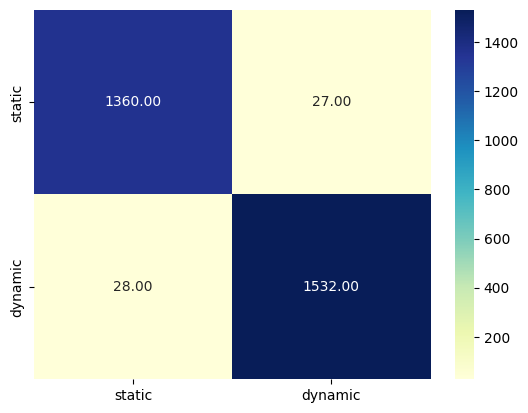

In [22]:
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

pred_dt = clf_dt.predict(X_test)

print("\n--- DT Classifier ---")


LABELS = ['static','dynamic']

y_pred= pred_dt
cm=confusion_matrix(static_y_test,y_pred)

#print(cm)
print('f1_score = ', f1_score(static_y_test, y_pred, average='weighted'))
print(accuracy_score(static_y_test,y_pred))
print(classification_report(static_y_test,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

